# Today I got a note from Tim Seres, the store manager for the downtown branch.

> Jacob-
> 
> We have daily sales data for the last four years, and we'd love some insight into how to schedule our salespeople. I certainly can't find any pattern in the data, but maybe you can with your 'machine learning' stuff? Let me know if you have any insights.
> 
> Thanks.
> 
> -Tim

## My tasks

* Explore the dataset
* If possible, create a model which can predict store sales

## Dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.tseries import holiday
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.inspection import permutation_importance
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')

# Data preparation

## Load Data

* When dealing with time-series data in pandas, reading in a CSV with the `parse_dates=` argument allows for seamless conversion of the dates into datetime objects.

In [2]:
df = pd.read_csv('store_sales_small.csv', parse_dates=["Order Date"])

## Clean data

* The datset is quite simple, with only dates and a sales total for each date, so it needs little preprocessing.
* I'll set a time feature to use in linear regression, but since there are some missing dates, I'll have to assign day numbers by delta since the start of the record-keeping.

In [3]:
start = pd.Timestamp(2014, 1, 3)
df['day_num'] = df['Order Date'].apply(lambda x: int((x - start).days))

# Create model to predict store sales

* N.B.: Max value for the Sales column is 10142.354 and min value is 1.788, so a random forest will not estimate outside those bounds

* Because of this, we will involve a linear regression in our ensemble (it's also an excellent, understandable baseline for our predictions.

## Linear regression as baseline

* When dealing with time-series data, we pass the argument `shuffle=False` to the `train_test_split()` in order to use the oldest observations as the training set; if this isn't done, we end up with leakage, as future information is known when it shouldn't be.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['day_num'],
    df['Sales'],
    shuffle=False,
    random_state=22,
    test_size=0.2
)

# Since we only have a single feature, the array needs to be reshaped to use in a sklearn clf
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

In [5]:
# Import linear regression and metrics
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error, r2_score

# Create and fit the regressor
reg = lr()
reg.fit(df['day_num'].values.reshape(-1,1), df['Sales'])

# Make predictions using the test set
test_preds = reg.predict(X_test)

# The coefficients
print('Coefficient: \n', reg.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, test_preds))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (R^2 score): %.2f' % r2_score(y_test, test_preds))

Coefficient: 
 [0.31372149]
Mean squared error: 1071008.80
Coefficient of determination (R^2 score): 0.01


* With an R^2 score of 0.01, a straight linear regression is a very weak model on its own!
* It does offer some insight into the overall trend, as the following visualization shows:

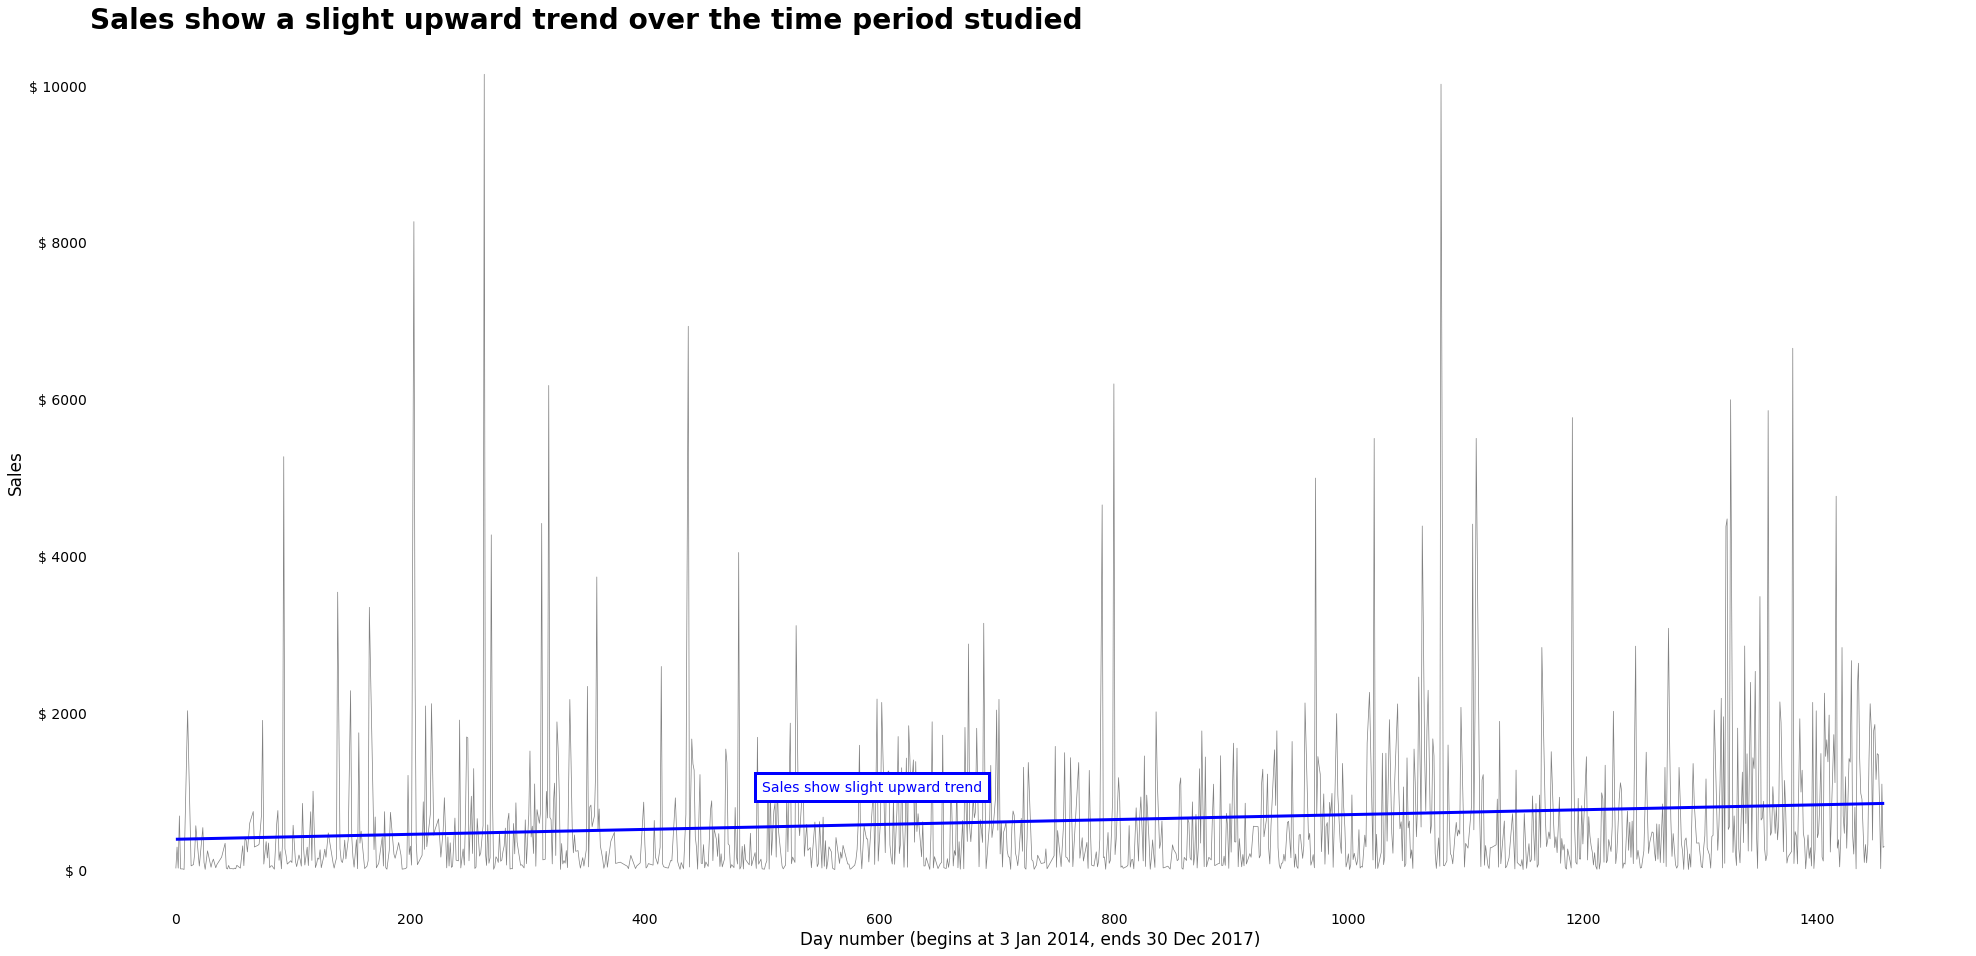

In [6]:
# Plot regression line
preds = reg.predict(df['day_num'].values.reshape(-1,1))

fig, ax = plt.subplots(figsize=(30, 15), facecolor='white')
plt.plot(df['day_num'], df['Sales'], color="grey", linewidth=0.7)
plt.plot(df['day_num'], preds, color="blue", linewidth=3)

ax.set_facecolor('white')
ax.grid(False)
ax.set_title('Sales show a slight upward trend over the time period studied',
             loc='left',
             fontdict={
                 'fontweight': 'bold',
                 'fontsize': 28
             }
            )
ax.set_xlabel('Day number (begins at 3 Jan 2014, ends 30 Dec 2017)')
ax.set_ylabel('Sales')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$ %d'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
 
ax.annotate('Sales show slight upward trend',
            xy=(500, 1000),
            color='blue',
            bbox=dict(fc='white', ec='blue', lw=3, pad=7)
           )

plt.savefig('viz/linear_regression.png', transparent=True)

## Lags

* Are lags predictive? Often they are; if so I'll add them to the dataframe.

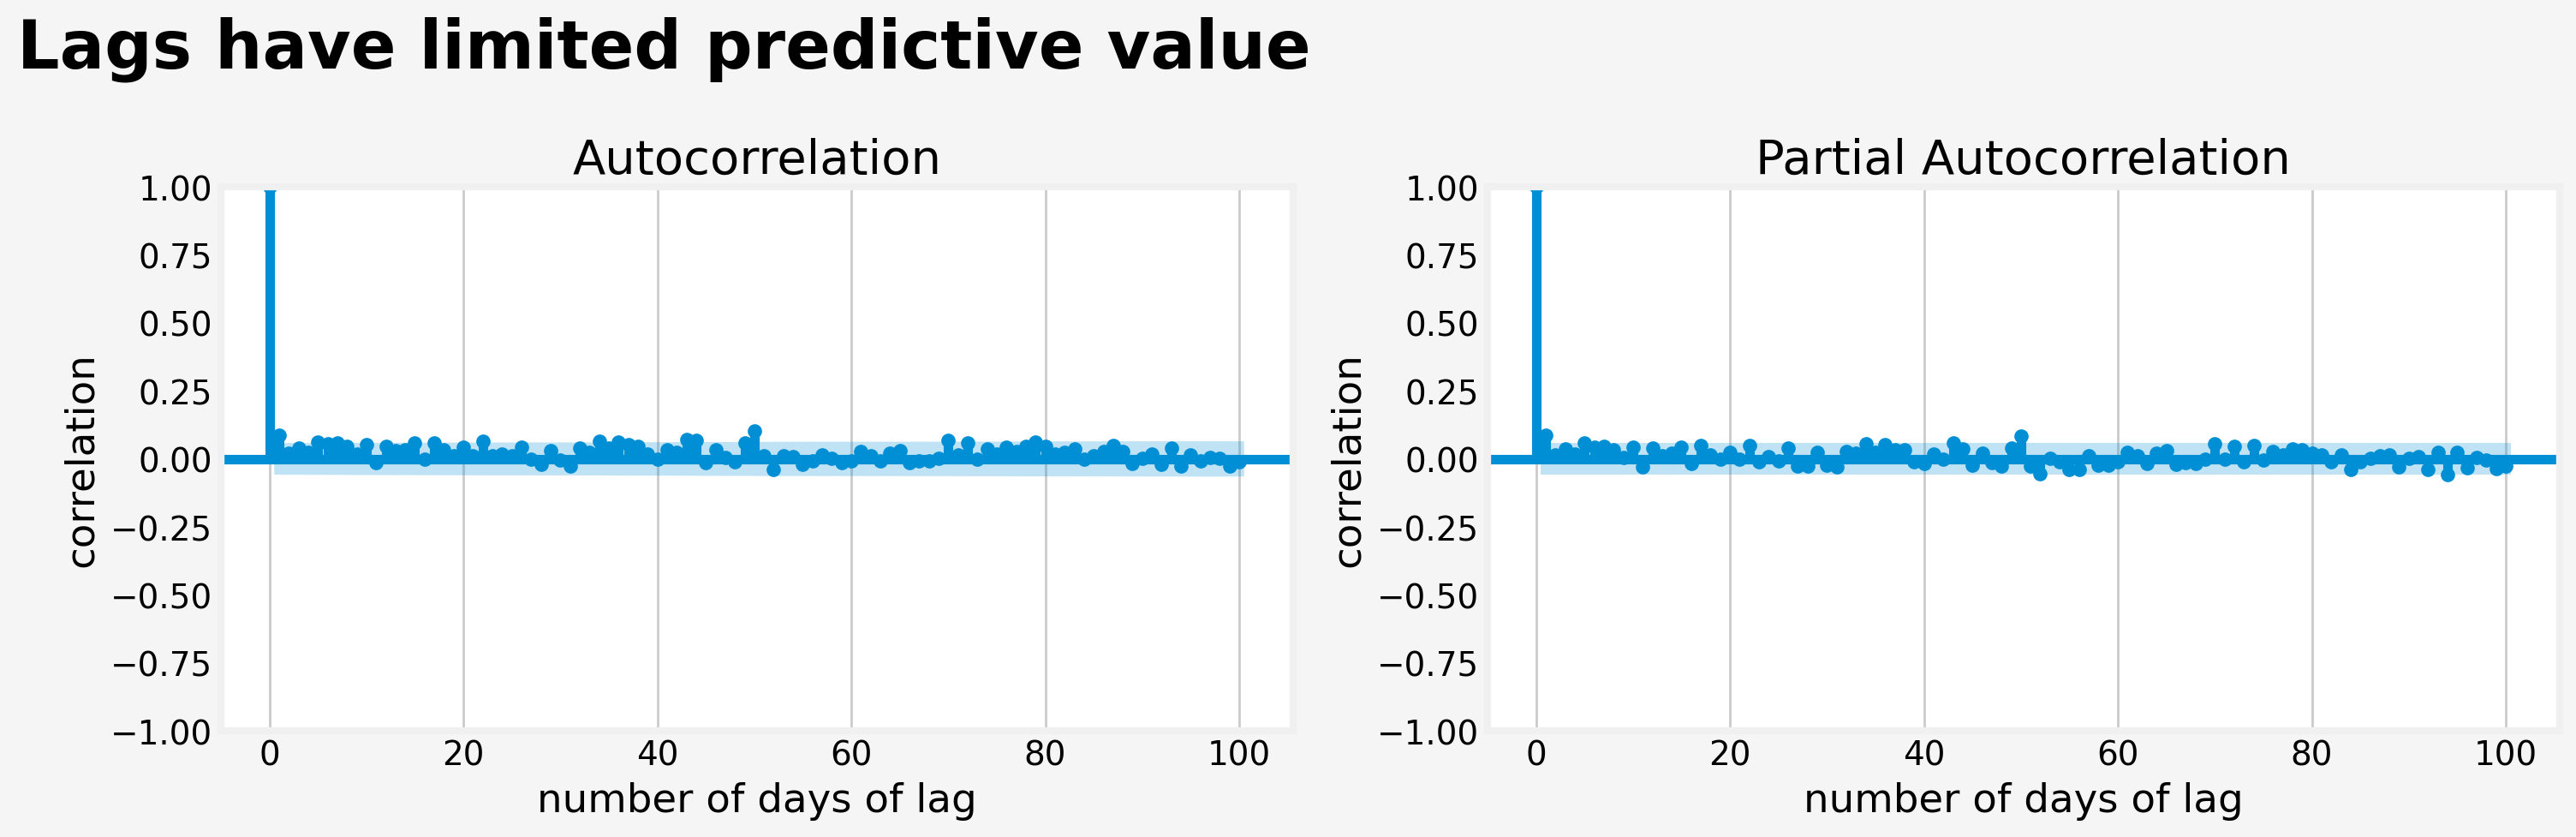

In [7]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi=200)
plot_acf(df['Sales'].tolist(), lags=100, ax=axes[0])
plot_pacf(df['Sales'].tolist(), lags=100, ax=axes[1], method='ywm')

fig.set_facecolor('whitesmoke')
fig.suptitle('Lags have limited predictive value',
            ha='right',
            size=28,
            weight='bold'
            )
for ax in axes.flat:
    ax.set(xlabel='number of days of lag', ylabel='correlation', facecolor='white')
    ax.grid(axis='y', visible=False)

plt.tight_layout()

plt.savefig('viz/lag_correlations.png')

* It seems as though lags have limited predictive value; a 50-day lag seems to have the highest positive correlation, interestingly, followed by a 1-day lag. The strongest negative correlations are 52- and 94-day lags.
* I'll go ahead and add those.

In [8]:
def add_lags(df, lag_vals):
    for val in lag_vals:
        col_name = f'lag_{val}'
        print(f'Adding column: {col_name}')
        df[col_name] = df['Sales'].shift(val)

useful_lags = [1, 50, 52, 94]
add_lags(df, useful_lags)

Adding column: lag_1
Adding column: lag_50
Adding column: lag_52
Adding column: lag_94


## An ensemble model

* This hybrid framework was the subject of a lecture during a Data Science Methods class I took; it involves combining linear regression and a tree-based model.

In [9]:
# Using a hybrid model like the one we learned in class
class BoostedHybrid:
    '''
    Runs model_1 on data, then runs model_2 on residuals of model_1
    
    In practice, model_1 detrends the data then model_2 uses a ML algorithm to forecast target values on detrended data
    '''
    
    def __init__(self, model_1, model_2, lags=[]):
        self.model_1 = model_1
        self.model_2 = model_2
        self.lags = lags

    def fit(self, X_1, X_2, y, train_size=0.9):
        '''
        X_1: entire dataset for linear regression(uses column 'Order Date')
        X_2: entire dataset for tree-based model ('all other dataset columns')
        y: target ('Sales')
        train_size: the fraction of the beginning of X_1 and X_2 to be used for training, the rest for test
        CAREFUL HERE TO NOT ACCIDENTALLY TRAIN ON TEST SET
        '''
        
        self.train_size=int(len(X_1)*train_size)
        self.test_size=len(X_1)-self.train_size
        lags = self.lags
        X_1 = X_1.copy()
        X_2 = X_2.copy()
        
        # fit the first model on train portion of dataset
        self.model_1.fit(X_1.iloc[0:self.train_size,:], y[:self.train_size]) # train model 1
        
        # generate residuals for entire dataset (only used to calculate lags)
        self.y_resid = y - self.model_1.predict(X_1)
        
        # compute and add the lags to X_2
        X_2['y_resid'] = self.y_resid
        for lag in lags:
            X_2['Lag_' + str(lag)] = X_2.y_resid.shift(lag)
        
        # alas, when adding lags, we must say goodbye to some rows
        X_2.dropna(inplace=True)  

        #save these residuals for later
        self.y_resid = X_2.y_resid
        
        #drop target from training data
        X_2.drop(columns=['y_resid'], inplace=True, axis=1)  # this gets rid of target values, so the model only sees past lags
        
        #fit the second model on residuals from first model, just the train data part
        self.model_2.fit(X_2.iloc[0:self.train_size,:], self.y_resid[:self.train_size])
        self.X_1 = X_1
        self.X_2 = X_2
        
    def predict(self):
        # to get a prediction add model_1's prediction to model_2's prediction
        X_1 = self.X_1.iloc[-self.test_size:,:]
        y_pred1 = self.model_1.predict(X_1)
        
        X_2 = self.X_2.iloc[-self.test_size:,:]
        y_pred2 = self.model_2.predict(X_2)
        
        return(y_pred1 + y_pred2)
    
    def score(self, X_1, X_2, y):
        return r2_score(y, self.predict())

### Evaluating a plain hybrid model

In [10]:
# Partitioning the dataset: get target value, the training set for linear regression, and the training set for random forest
y = df['Sales']
X_1 = df.loc[:,['day_num']]
X_2 = df.loc[:,['day_num']]

In [11]:
# Create instance of BoostedHybrid model with no lags,
# passing a linear regressor object and a random forest regressor object as the two models
hm = BoostedHybrid(model_1=lr(), model_2=rfr(random_state=22))

# Fit the model
hm.fit(X_1, X_2, y)

# Predict
preds = hm.predict()

# Check R^2
print(f'(R^2 score): {r2_score(y[-len(preds):], preds)}')

(R^2 score): -0.6921898714595429


* Wow, with a negative R^2 score, we can safely say this a terrible model, much worse than simply using linear regression by itself. Let's see if the random forest needs tuning, using optuna.

#### Tuning the RF hyperparams for plain hybrid

In [12]:
import optuna
from sklearn.model_selection import cross_val_score

# Silence the optuna output except for errors
optuna.logging.set_verbosity(optuna.logging.WARNING)

# First tune the random forest
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 205, step=10)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    clf = rfr(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    return cross_val_score(clf, X_2, y, n_jobs=-1).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Then pass the tuned RF into the hybrid model
model_2 = rfr(random_state=22, **study.best_params)

hm_with_tuned_rf = BoostedHybrid(model_1=lr(), model_2=model_2)

# Fit the model
hm_with_tuned_rf.fit(X_1, X_2, y)

# Predict
tuned_preds = hm_with_tuned_rf.predict()

# Check R^2
print(f'R^2 score: {r2_score(y[-len(tuned_preds):], tuned_preds)}')

R^2 score: -0.30578100603976344


* Pre-tuned R^2: __-0.692__
* Post-tuned R^2: __-0.306__ (varies slightly with random nature of tuning)

Better, but still not a good model; linear regression by itself still wins the day!

### Evaluating a hybrid model with lags

In [13]:
X_2_lags = df.loc[:,['day_num', 'lag_1', 'lag_50', 'lag_52', 'lag_94']].dropna()

In [14]:
y_lags = y[-len(X_2_lags):]

* This time we will go straight to tuning with optuna

#### Tuning the RF hyperparams for hybrid with lags

In [15]:
# First tune the random forest
# (the optuna output remains silenced from the earlier setting)
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 205, step=10)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    clf = rfr(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    return cross_val_score(clf, X_2_lags, y_lags, n_jobs=-1).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Then pass the tuned RF into the hybrid model
model_2 = rfr(random_state=22, **study.best_params)

hm_with_lags = BoostedHybrid(model_1=lr(), model_2=model_2)

# Fit the model
hm_with_lags.fit(X_1, X_2_lags, y)

# Predict
lags_preds = hm_with_lags.predict()

# Check R^2
print(f'R^2 score: {r2_score(y[-len(lags_preds):], lags_preds)}')

R^2 score: -0.08174728935628672


* Pre-tuned plain hybrid R^2: __-0.692__
* Post-tuned plain hybrid R^2: __-0.306__
* Post-tuned hybrid with lags R^2: __-0.082__

With lags, we get better performance, but that's mostly because the plain hybrid model was *so terrible*. We're still not at the level of straight linear regression, though, which is disappointing, but informative. I'll try adding a couple of additional features to see if they help.

### Feature engineering

* On the assumption that this store is based in the US, let's add some features

#### Weekends

* Since we read in the 'Order Date' column as a datetime object, we have access to additional useful information about each date

In [16]:
df['is_weekend'] = df['Order Date'].apply(lambda x: 1 if x.dayofweek in [5, 6] else 0)

#### Holidays

* Despite limited documentation on the pandas holiday package, I managed to create this feature!

In [17]:
cal = holiday.AbstractHolidayCalendar(rules=holiday.USFederalHolidayCalendar.rules)
hols = np.array(cal.holidays())

In [18]:
df['is_holiday'] = df['Order Date'].isin(hols).astype(int)

#### Back-to-school

* I'll define "back-to-school shopping" as the month of August, for the sake of simplicity

In [19]:
df['is_bts'] = df['Order Date'].apply(lambda x: 1 if x.month == 8 else 0)

### Evaluating a tuned hybrid model with additional features

In [20]:
# Create a new df which has all available features
X_2_feats = df.loc[:, ['day_num', 'lag_1', 'lag_50', 'lag_52', 'lag_94', 'is_weekend', 'is_holiday', 'is_bts']].dropna()

In [21]:
# Tune the random forest
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 5, 205, step=10)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    clf = rfr(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    return cross_val_score(clf, X_2_feats, y[-len(X_2_feats):], n_jobs=-1).mean()

feat_study = optuna.create_study(direction='maximize')
feat_study.optimize(objective, n_trials=30)

In [22]:
# Then pass the tuned RF into the hybrid model
model_2 = rfr(random_state=22, **feat_study.best_params)

hm_with_feats = BoostedHybrid(model_1=lr(), model_2=model_2)

# Fit the model
hm_with_feats.fit(X_1, X_2_feats, y)

# Predict
feats_preds = hm_with_feats.predict()

# Check R^2
print(f'R^2 score: {r2_score(y[-len(feats_preds):], feats_preds)}')

R^2 score: 0.0806961619711174


* Pre-tuned plain hybrid R^2: __-0.692__
* Post-tuned plain hybrid R^2: __-0.306__
* Post-tuned hybrid with lags R^2: __-0.082__
* Post-tuned hybrid with added features R^2: __0.081__

With the added features, we get the best performance thus far. Just for fun, let's test the added features without tuning the RF.

In [23]:
hm_with_feats_no_tuning = BoostedHybrid(model_1=lr(), model_2=rfr(random_state=22))

# Fit the model
hm_with_feats_no_tuning.fit(X_1, X_2_feats, y)

# Predict
feats_no_tune_preds = hm_with_feats_no_tuning.predict()

# Check R^2
print(f'R^2 score: {r2_score(y[-len(feats_no_tune_preds):], feats_no_tune_preds)}')

R^2 score: 0.7265985736466342


* Pre-tuned plain hybrid R^2: __-0.692__
* Post-tuned plain hybrid R^2: __-0.306__
* Post-tuned hybrid with lags R^2: __-0.082__
* Post-tuned hybrid with added features R^2: __0.081__
* Pre-tuned hybrid with added features R^2:__0.727__!

Now *that* begs further study...either I'm using optuna incorrectly, or I've evaluated at least one of my models incorrectly. A subject for future learning!

### Visualization of the best hybrid model

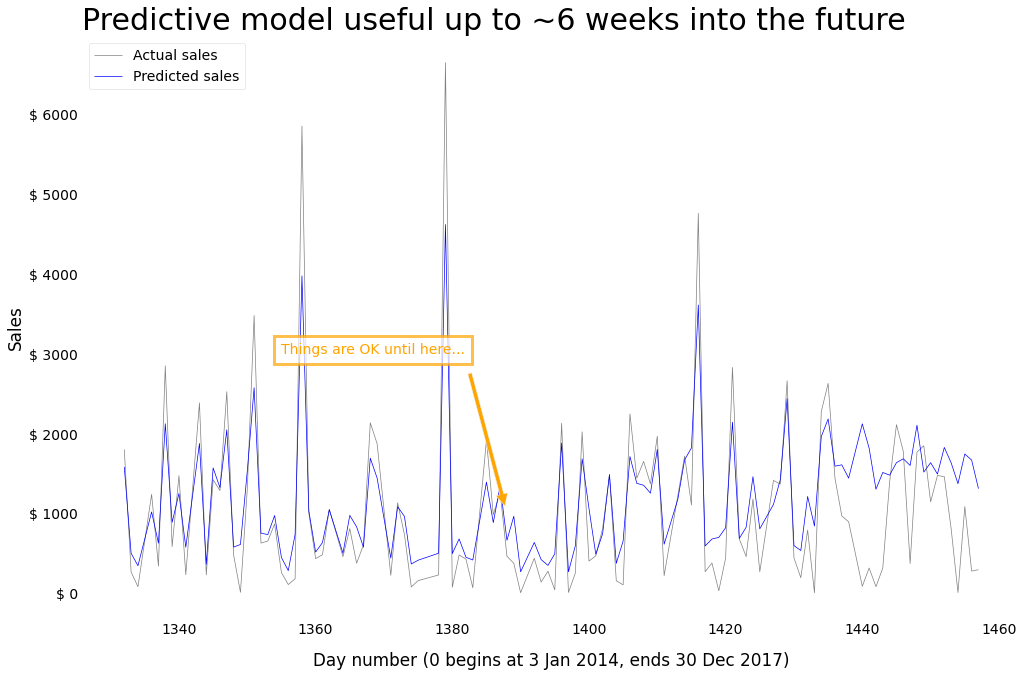

In [28]:
start = -len(feats_no_tune_preds)

fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')
plt.plot(df['day_num'][start:], y[start:], linewidth=0.7, color='grey', label='Actual sales')
plt.plot(df['day_num'][start:], feats_no_tune_preds, linewidth=0.7, color='blue', label='Predicted sales')

ax.set_facecolor('white')
ax.grid(False)
ax.set_title('Predictive model useful up to ~6 weeks into the future', loc='left', size=30)
ax.set_xlabel('Day number (0 begins at 3 Jan 2014, ends 30 Dec 2017)', labelpad=15)
ax.set_ylabel('Sales')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('$ %d'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.annotate('Things are OK until here...',
            xy=(1388, 1000),
            xytext=(1355, 3000),
            color='orange',
            bbox=dict(fc='white', ec='orange', lw=3, pad=7, alpha=0.7),
            arrowprops=dict(facecolor='orange', shrink=0.05))

plt.legend(facecolor='white', loc='upper left')

plt.savefig('viz/best_model_preds.png', transparent=True)

### Feature importance

In [25]:
regressor = rfr(random_state=22).fit(X_2_feats, y[-len(X_2_feats):])

r = permutation_importance(regressor, X_2_feats, y[-len(X_2_feats):], 
                           n_repeats=30, random_state=22, scoring='r2')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f'{X_2_feats.columns[i]:<8}'
              f'{r.importances_mean[i]:.3f}'
              f' +/- {r.importances_std[i]:.3f}')

day_num 0.482 +/- 0.019
lag_50  0.441 +/- 0.022
lag_52  0.297 +/- 0.019
lag_1   0.294 +/- 0.020
lag_94  0.228 +/- 0.012
is_weekend0.022 +/- 0.002
is_holiday0.020 +/- 0.001
is_bts  0.006 +/- 0.001


* The most important feature for the model is the day number, followed by the lags. This is easier to grasp in a visual, though.

In [26]:
forest_importances = pd.Series(r.importances_mean, index=X_2_feats.columns).sort_values()

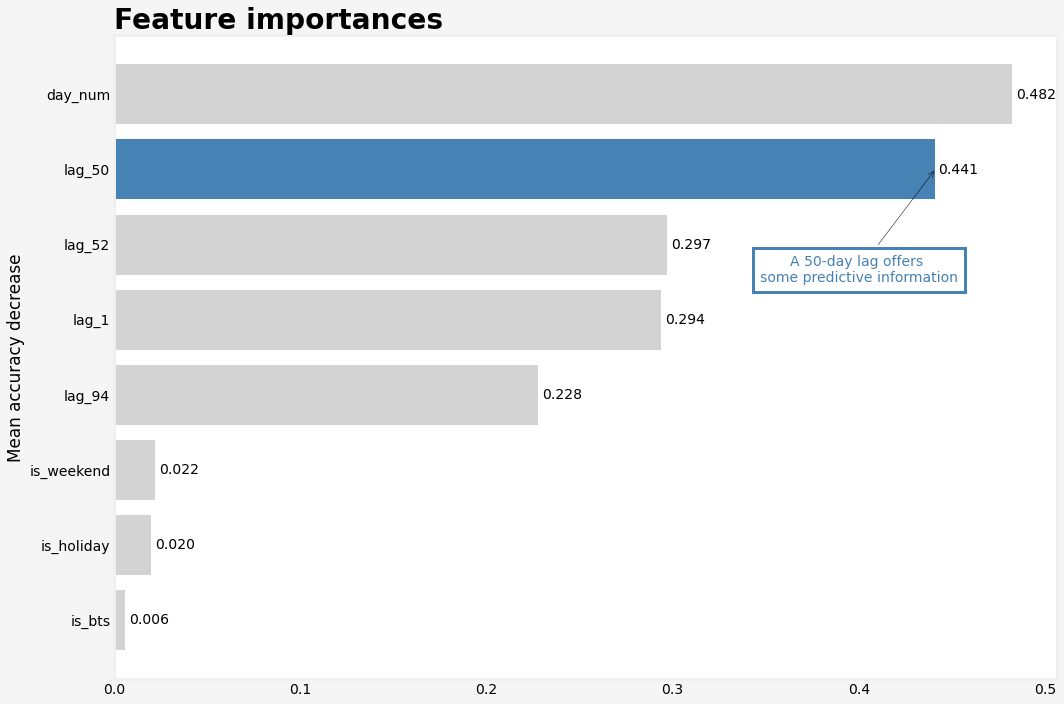

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

colors = ['lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'steelblue', 'lightgray']

bars = ax.barh(forest_importances.index, forest_importances, color=colors)

fig.set_facecolor('whitesmoke')
_ = ax.bar_label(bars, padding=4, fmt='%.3f')
# forest_importances.plot.barh(yerr=result.importances_std, ax=ax)
_ = ax.set_title('Feature importances',
                 loc='left',
                 fontdict={
                     'fontsize': 28,
                     'fontweight': 'bold'
                 }
                )
_ = ax.set_ylabel('Mean accuracy decrease')
ax.set_facecolor('white')
ax.grid(visible=False)
ax.annotate(
    text='A 50-day lag offers \nsome predictive information',
    color='steelblue',
    ha='center',
    xy=(0.441, 6),
    xytext=(0.4, 4.5),
    arrowprops=dict(arrowstyle='->', color='black', connectionstyle='arc3'),
    bbox=dict(fc='white', ec='steelblue', lw=3, pad=7)
)
fig.tight_layout()
plt.show()
fig.savefig('viz/rf_feature_importances.png')

# Insights

* Hybrid model predictive accuracy is fairly good for the first ~50 days of the dataset, so it is a useful tool in scheduling.
* Particularly important is the fact that the general contour of the predictions closely matches the actual sales, suggesting that when a spike is predicted, more sales reps should be scheduled, even if the actual size of the spike isn't perfectly accurate.
* The model tends to underestimate sales spikes by ~40%, so if one rep can handle ~ \\$1000 in daily sales, and a spike of $3000 is predicted, 4 reps should be scheduled.
* Hybrid model predictive accuracy declines significantly 100+ days in the future, so long-term hiring decisions are better informed by the simple linear model.

## Areas for further investigation
* The simple 'day number' feature has the highest permutation importance; this seems fishy to me, as though perhaps I have some (or a lot of) data leakage, since day_num shouldn't really have information in it. I would try modeline without that feature to see if I still have predictive power.
* The fact that a 50-day lag is more predictive than a 1-day lag is fascinating. It makes me want to know more about the fluctuations in our sales; likely there is additional information that could be incorporated (the timing of promotional campaigns, perhaps?)!